In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=15

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4000 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Early blight', 'Healthy and late blight']

(32, 256, 256, 3)
[1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1]


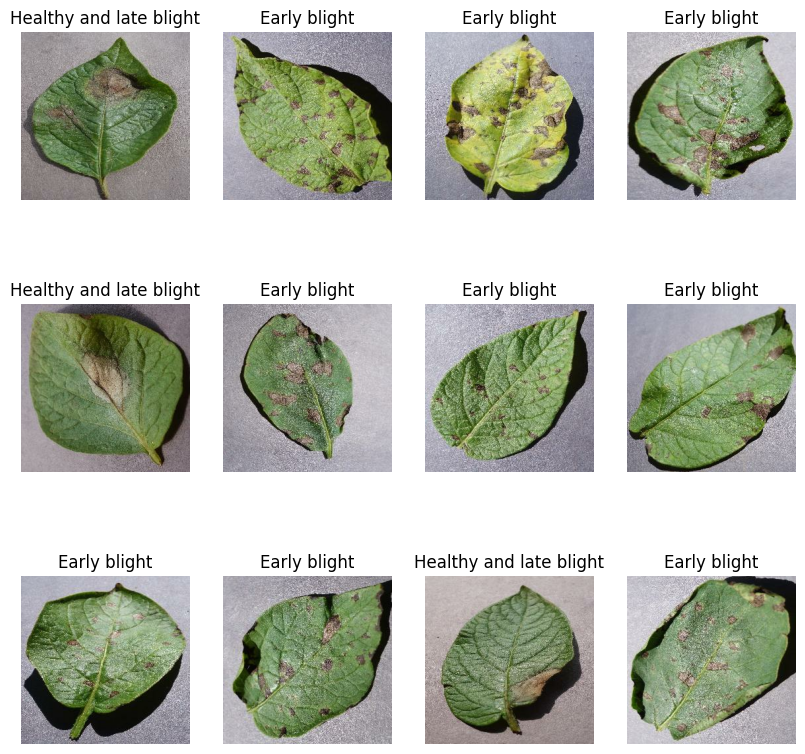

In [5]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):#12 images
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))#imshow pass 2d array ,i tensor to numpy ,float to uint8
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
#training and testing dataset
#validation for each epochs fro accuracy
# 80%->training 10% test=> 10%->validation 10%->testing

In [7]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+val_split+test_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)# seed same samples
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)#test dataset
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [9]:
len(train_ds)

100

In [10]:
len(val_ds)

12

In [11]:
len(test_ds)

13

In [12]:
161*32

5152

In [13]:
#cache,shuffle,fetch


In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)# cache->disk to memory faster access laoding
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#images in numpy array

In [15]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[143. 131. 131.]
  [132. 120. 120.]
  [130. 118. 118.]
  ...
  [147. 133. 132.]
  [159. 145. 144.]
  [147. 133. 132.]]

 [[150. 138. 138.]
  [136. 124. 124.]
  [130. 118. 118.]
  ...
  [140. 126. 125.]
  [142. 128. 127.]
  [134. 120. 119.]]

 [[146. 134. 134.]
  [141. 129. 129.]
  [138. 126. 126.]
  ...
  [140. 126. 125.]
  [147. 133. 132.]
  [155. 141. 140.]]

 ...

 [[190. 179. 183.]
  [182. 171. 175.]
  [179. 168. 172.]
  ...
  [199. 189. 187.]
  [197. 187. 185.]
  [195. 185. 183.]]

 [[184. 173. 177.]
  [176. 165. 169.]
  [176. 165. 169.]
  ...
  [200. 190. 188.]
  [198. 188. 186.]
  [195. 185. 183.]]

 [[182. 171. 175.]
  [175. 164. 168.]
  [177. 166. 170.]
  ...
  [200. 190. 188.]
  [198. 188. 186.]
  [195. 185. 183.]]]


In [16]:
#normalise divide by 255
#create keras layer to normalise

In [17]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),# if image is not 256x256 in actual production
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
#for random flip random rotation

In [19]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),# if image is not 256x256 in actual production
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
       layers.experimental.preprocessing.RandomContrast(0.2)
])

In [20]:
#model

In [21]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [23]:
#compile model


In [24]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [25]:
history=model.fit(
  train_ds,
  batch_size=BATCH_SIZE,
  validation_data=val_ds,
  verbose=1,#detail information
  epochs=EPOCHS
)

Epoch 1/15
100/100 [==============================] - 310s 3s/step - loss: 0.6288 - accuracy: 0.6425 - val_loss: 0.4988 - val_accuracy: 0.7266
Epoch 2/15
100/100 [==============================] - 298s 3s/step - loss: 0.2815 - accuracy: 0.8809 - val_loss: 0.2001 - val_accuracy: 0.9271
Epoch 3/15
100/100 [==============================] - 305s 3s/step - loss: 0.1910 - accuracy: 0.9200 - val_loss: 0.1673 - val_accuracy: 0.9349
Epoch 4/15
100/100 [==============================] - 295s 3s/step - loss: 0.1188 - accuracy: 0.9522 - val_loss: 0.0589 - val_accuracy: 0.9740
Epoch 5/15
100/100 [==============================] - 274s 3s/step - loss: 0.1085 - accuracy: 0.9597 - val_loss: 0.0409 - val_accuracy: 0.9896
Epoch 6/15
100/100 [==============================] - 246s 2s/step - loss: 0.0883 - accuracy: 0.9669 - val_loss: 0.0836 - val_accuracy: 0.9635
Epoch 7/15
100/100 [==============================] - 240s 2s/step - loss: 0.0597 - accuracy: 0.9787 - val_loss: 0.0179 - val_accuracy: 0.9948

In [26]:
scores=model.evaluate(test_ds)

13/13 [==============================] - 38s 521ms/step - loss: 0.0060 - accuracy: 0.9952


In [27]:
scores   

[0.0060363709926605225, 0.995192289352417]

In [28]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 100}

In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


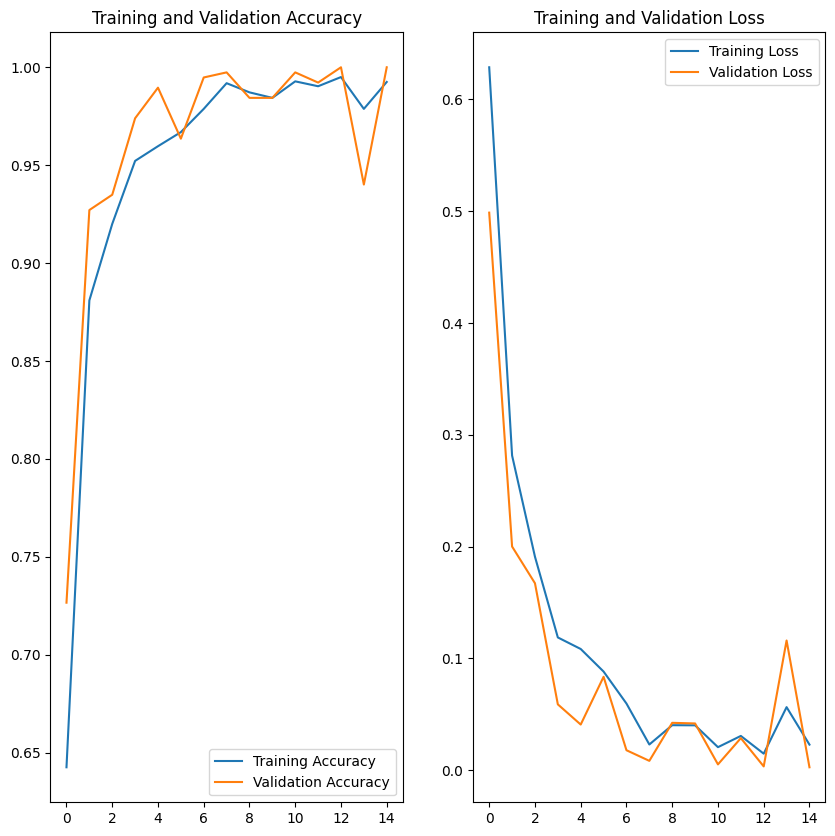

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual Labels: Early blight
1/1 [==============================] - 2s 2s/step
Predicted Label: Early blight


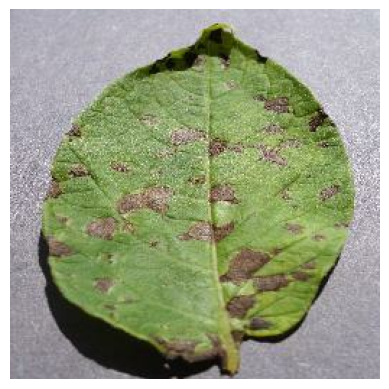

In [31]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    plt.imshow(first_image)
    print("Actual Labels:",class_names[labels_batch[0].numpy()])
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [32]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 39ms/step


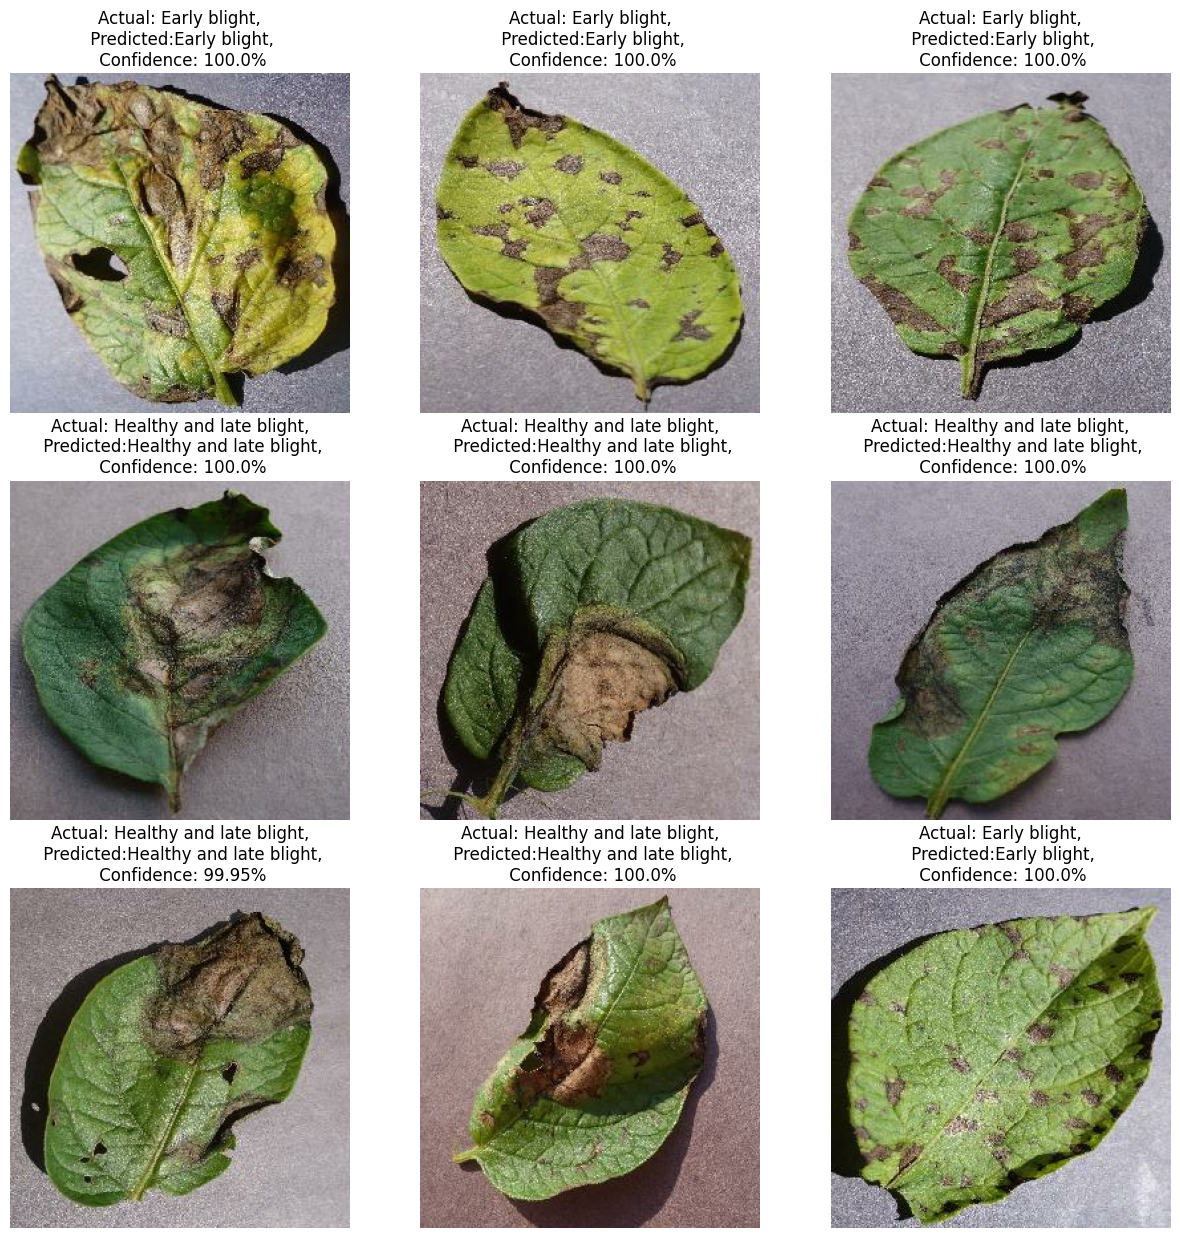

In [33]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")


In [34]:
model.save("myModel.h5")

C:\Users\Rangoli\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
